## Setup

# Filter Robustness Analysis - Site Classification

## Objective
Test whether the site classification results are robust to different preprocessing filter configurations.

## Filter Configurations Tested
- **original:** Standard preprocessing pipeline
- **remove_low_freq_artifacts:** Stricter low-frequency filtering
- **remove_high_freq_artifacts:** Stricter high-frequency filtering
- **strict_both_ends:** Stricter filtering on both ends
- **clinical_range:** Clinical EEG frequency range only (~0.5-40 Hz)

## Key Results

| Filter | Overall MCC |
|--------|-------------|
| original | 0.866 |
| remove_high_freq_artifacts | 0.867 |
| remove_low_freq_artifacts | 0.864 |
| strict_both_ends | 0.861 |
| clinical_range | 0.857 |

## Conclusion
**Results are robust across all filter configurations.** The site effect phenomenon (high site classifiability) holds regardless of preprocessing choices. MCC range is narrow: 0.857-0.867.

This validates that the paradox finding is not an artifact of a specific preprocessing pipeline.

In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [2]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from src.visualization.eeg_plots import plot_eeg_feature_overview

LOG_FILE_PATH = 'results/logs/05_experiment_filters/site_clf.log'
RESULTS_PATH = 'results/tables/05_experiment_filters/site_clf_results.csv'

PIPELINE_SAVE_DIR = 'models/05_experiment_filters/site_clf_pipelines'
SHAP_DATA_SAVE_DIR = 'results/shap_data/05_experiment_filters/site_clf'


METHODS = ['raw']
FEATURES = [
        'original',
        'remove_low_freq_artifacts',
        'remove_high_freq_artifacts',
        'strict_both_ends',
        'clinical_range'
]

In [3]:
results_df = pd.read_csv(RESULTS_PATH)

In [4]:
results_df

,mcc_overall,mcc_AKS,mcc_ARCHDAM,mcc_B2K,mcc_CHE,mcc_CMD,mcc_GAK,mcc_KAL,mcc_KATMOJPRZ,mcc_KIEG,...,mcc_STG1,mcc_SZC,mcc_TER_L,mcc_TOR,mcc_WLU,mcc_Z04O,mcc_ZOZLO,method,fold,tag
0,0.866049,0.491610,0.865634,0.932064,0.419530,0.175122,0.752731,0.936847,0.916436,0.401673,...,0.889768,0.891958,0.712965,0.940871,0.928266,0.913848,0.803668,raw,1,original
1,0.863070,0.594790,0.875305,0.937952,0.352687,0.301041,0.760992,0.908898,0.916628,0.346908,...,0.914453,0.885536,0.637638,0.922494,0.903986,0.914374,0.740543,raw,2,original
2,0.866012,0.579684,0.865634,0.945239,0.119953,0.276063,0.670109,0.891914,0.915030,0.284789,...,0.927984,0.884296,0.659700,0.954662,0.891374,0.920464,0.828513,raw,3,original
3,0.870878,0.511352,0.872469,0.951712,0.419530,0.075477,0.750455,0.975003,0.939389,0.368613,...,0.907524,0.890104,0.686960,0.927862,0.893692,0.924929,0.740082,raw,4,original
4,0.863278,0.420898,0.854545,0.952885,0.000000,0.115594,0.799755,0.949928,0.913069,0.300943,...,0.916443,0.884914,0.673133,0.933315,0.905748,0.930412,0.760241,raw,5,original
5,0.862049,0.535219,0.856308,0.920608,0.457329,0.166760,0.726408,0.924852,0.921640,0.521445,...,0.896475,0.883622,0.701268,0.954820,0.912252,0.891939,0.799719,raw,1,remove_low_freq_artifacts
6,0.860193,0.596638,0.870069,0.933537,0.444369,0.235946,0.760122,0.914393,0.907842,0.172370,...,0.884770,0.884221,0.656717,0.929819,0.905335,0.925643,0.770385,raw,2,remove_low_freq_artifacts
7,0.870855,0.509785,0.868755,0.938129,0.279238,0.311330,0.671076,0.897876,0.925287,0.380378,...,0.933321,0.886528,0.690955,0.958391,0.881879,0.897019,0.857624,raw,3,remove_low_freq_artifacts
8,0.863939,0.483050,0.864450,0.928796,0.342512,0.186279,0.665091,0.939796,0.931179,0.434176,...,0.912809,0.887606,0.687241,0.928526,0.871641,0.903782,0.726689,raw,4,remove_low_freq_artifacts
9,0.863525,0.409601,0.861159,0.943355,0.170707,0.249186,0.765860,0.937390,0.920152,0.245231,...,0.927082,0.882478,0.650615,0.932294,0.906396,0.910894,0.789413,raw,5,remove_low_freq_artifacts


In [5]:
mean_results_df = results_df.drop(['method', 'fold'], axis=1).groupby(['tag']).mean()

In [6]:
mean_results_df

,mcc_overall,mcc_AKS,mcc_ARCHDAM,mcc_B2K,mcc_CHE,mcc_CMD,mcc_GAK,mcc_KAL,mcc_KATMOJPRZ,mcc_KIEG,...,mcc_SL2,mcc_SLU,mcc_SRK,mcc_STG1,mcc_SZC,mcc_TER_L,mcc_TOR,mcc_WLU,mcc_Z04O,mcc_ZOZLO
tag,,,,,,,,,,,,,,,,,,,,,
clinical_range,0.857473,0.539868,0.867200,0.908033,0.413439,0.197731,0.742385,0.919119,0.921036,0.248483,...,0.512421,0.880485,0.827566,0.922520,0.880716,0.679352,0.941195,0.895232,0.899829,0.771089
original,0.865857,0.519667,0.866718,0.943970,0.262340,0.188659,0.746808,0.932518,0.920110,0.340585,...,0.453634,0.878151,0.849763,0.911235,0.887362,0.674079,0.935841,0.904613,0.920805,0.774610
remove_high_freq_artifacts,0.866543,0.525030,0.870706,0.941428,0.337053,0.198141,0.743478,0.926007,0.921861,0.283165,...,0.473132,0.870365,0.873928,0.912839,0.888033,0.683466,0.940671,0.903104,0.922298,0.787933
remove_low_freq_artifacts,0.864112,0.506859,0.864148,0.932885,0.338831,0.229900,0.717711,0.922861,0.921220,0.350720,...,0.448383,0.883239,0.858460,0.910891,0.884891,0.677359,0.940770,0.895501,0.905855,0.788766
strict_both_ends,0.861255,0.527127,0.866573,0.906524,0.305866,0.189458,0.729707,0.933629,0.921404,0.280797,...,0.500179,0.888422,0.857293,0.916960,0.885180,0.678155,0.947028,0.892481,0.902920,0.759726


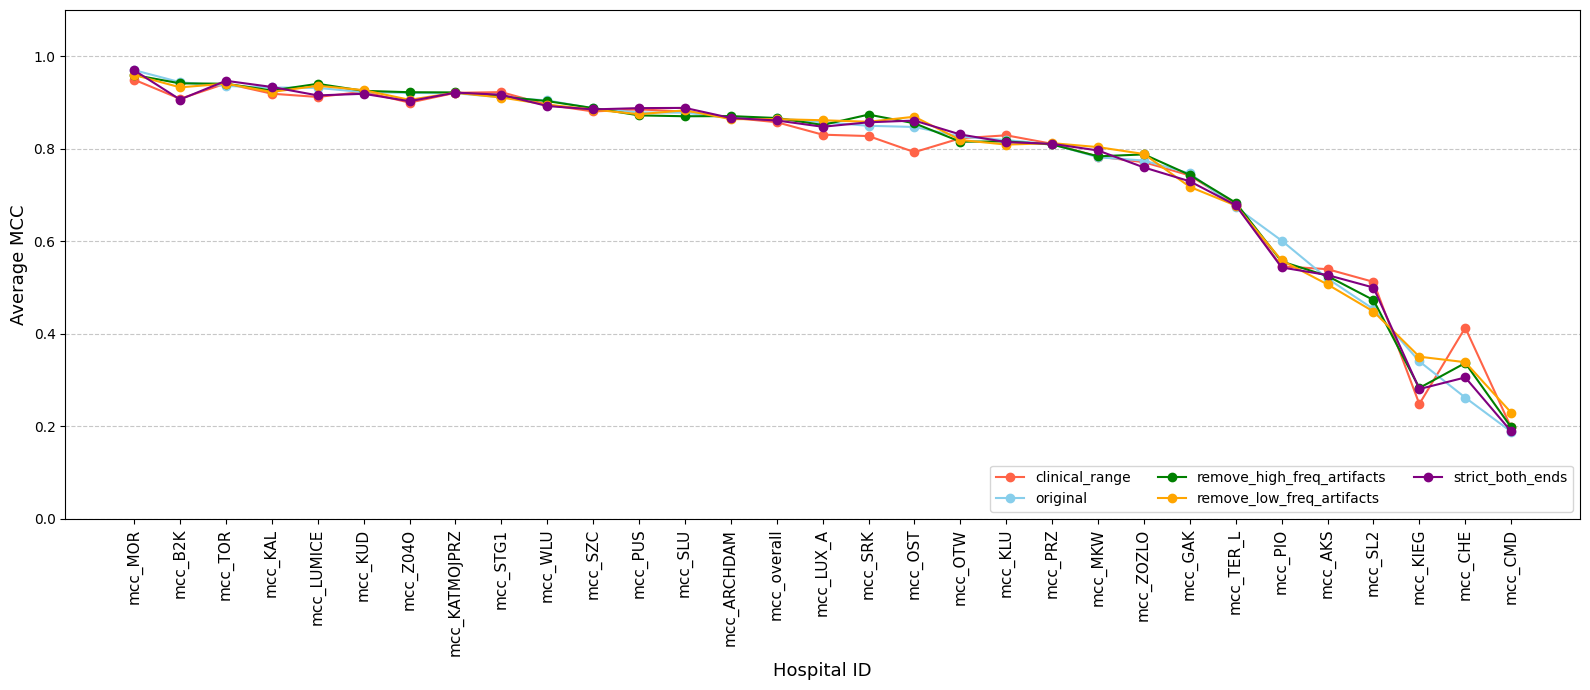

In [7]:
color_grid = [
    'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

plt.figure(figsize=(16, 7))

reference_series = mean_results_df.loc['original']
sort_idx = reference_series.values.argsort()[::-1]
class_labels_sorted = reference_series.index.values[sort_idx]
for method_idx, method in enumerate(mean_results_df.index):
    results_series = mean_results_df.loc[method]
    mcc_values = [results_series.get(h, np.nan) for h in class_labels_sorted]

    plt.plot(
        class_labels_sorted,
        mcc_values,
        marker='o',
        linestyle='-',
        color=color_grid[method_idx],
        label=f"{method}"
    )

plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)
plt.legend(loc='lower right', fontsize=10, ncol=3)
plt.tight_layout()

plt.show()

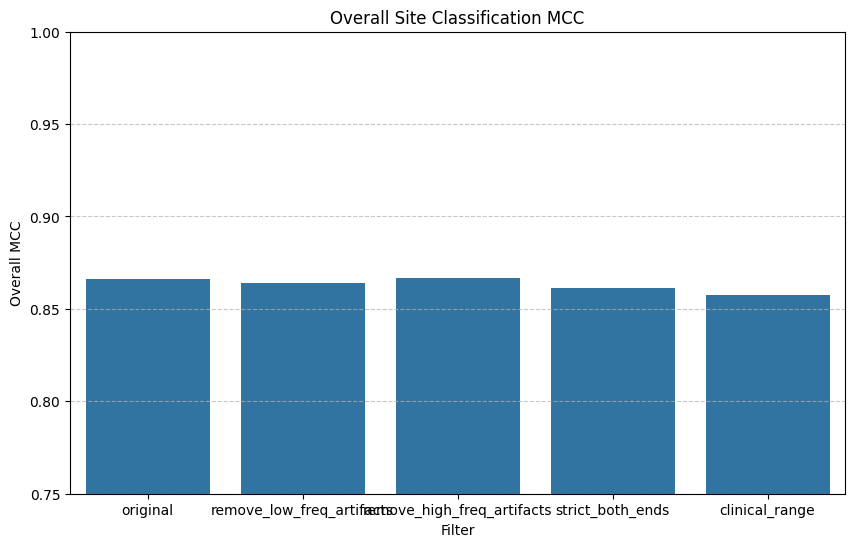

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_results_df, x='tag', y='mcc_overall', order=FEATURES)
plt.title('Overall Site Classification MCC')
plt.ylabel('Overall MCC')
plt.xlabel('Filter')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0.75, 1)
plt.show()

### SHAP analysis

In [ ]:
pipelines = {}
test_data = {}
logging.info("Loading all pipelines and test data...")
method = 'raw'
for filter in FEATURES:
    pipeline_path = os.path.join(PIPELINE_SAVE_DIR, f'{method}_{filter}_pipeline_fold0.joblib')
    pipelines[f"{method}_{filter}"] = joblib.load(pipeline_path)

    data_path = os.path.join(SHAP_DATA_SAVE_DIR, f'{method}_{filter}_test_data_fold0.parquet')
    test_data[f"{method}_{filter}"] = pd.read_parquet(data_path)

In [ ]:
transformed_X = {}
feature_names = {}
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    if key not in pipelines:
        continue
    pipeline = pipelines[key]
    data_df = test_data[key]

    y_test = data_df['y_true_hospital']
    X_test = data_df.drop(columns=['y_true_hospital'])

    model = pipeline.named_steps['clf']
    feature_names[key] = model.feature_names_

    if method == 'raw':
        X_transformed = X_test
    else:
        X_transformed = pipeline.named_steps['harmonize'].transform(X_test)

    transformed_X[key] = pd.DataFrame(X_transformed, columns=feature_names[key])

In [ ]:
shap_values = {}
explainers = {}
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    if key not in pipelines:
        continue

    model = pipelines[key].named_steps['clf']
    X = transformed_X[key]

    explainers[key] = shap.TreeExplainer(model)
    shap_values[key] = explainers[key](X)

In [ ]:
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    mean_abs_shap = np.mean(np.abs(shap_values[key].values), axis=(0, 2))
    shap_series = pd.Series(mean_abs_shap, index=transformed_X[key].columns)

    fig, axs = plot_eeg_feature_overview(
        features_series=shap_series,
        figure_title=f"Method: {method}, Filter: {filter}"
    )
    save_path = f"results/figures/05_experiment_filters/{key}_shap_overview.png"
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    logging.info(f"Saved plot to {save_path}")

    plt.show()

In [ ]:
method = 'raw'
for filter in FEATURES:
    key = f"{method}_{filter}"
    mean_abs_shap = np.mean(np.abs(shap_values[key].values), axis=0)
    model = pipelines[key].named_steps['clf']
    for idx, hospital_id in enumerate(model.classes_):
        shap_series = pd.Series(mean_abs_shap[:,idx], index=transformed_X[key].columns)

        fig, axs = plot_eeg_feature_overview(
            features_series=shap_series,
            figure_title=f"Method: {method}, Filter: {filter}, Hospital ID: {hospital_id}"
        )

        save_path_dir = f"results/figures/05_experiment_filters/{key}"
        os.makedirs(save_path_dir, exist_ok=True)
        save_path = save_path_dir + f"/{key}_{hospital_id}_shap_overview.png"
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        logging.info(f"Saved plot to {save_path}")

        plt.close(fig)

In [21]:
metrics_original = pd.read_csv("data/ELM19/experiments/original/metrics.csv")
metrics_low = pd.read_csv("data/ELM19/experiments/remove_low_freq_artifacts/metrics.csv")

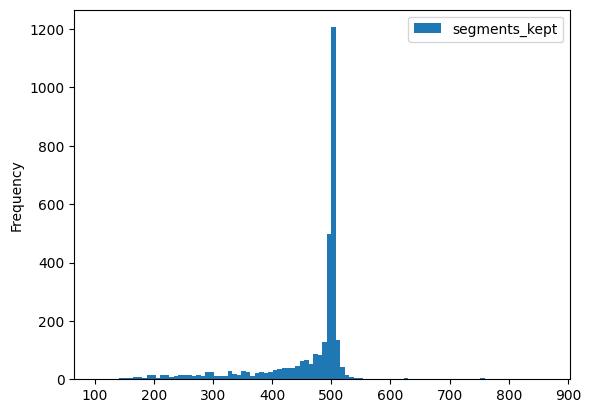

<Axes: ylabel='Frequency'>

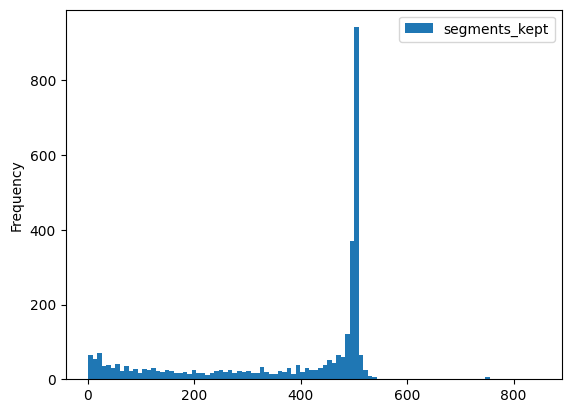

In [24]:
metrics_original[metrics_original['institution_id'] == 'Z04O'].plot.hist(column=["segments_kept"], bins=100)
plt.show()
metrics_low[metrics_low['institution_id'] == 'Z04O'].plot.hist(column=["segments_kept"], bins=100)

In [18]:
metrics.columns

Index(['examination_id', 'institution_id', 'data_group',
       'processing_timestamp', 'processing_duration_s', 'sampling_freq_hz',
       'recording_duration_s', 'n_channels', 'preprocessing_successful',
       'failure_reason', 'n_warnings', 'raw_mean_amp_uv', 'raw_std_amp_uv',
       'raw_max_amp_uv', 'raw_median_mad_uv', 'prep_mean_amp_uv',
       'prep_std_amp_uv', 'prep_max_amp_uv', 'prep_median_mad_uv',
       'total_segments', 'rejected_amplitude', 'rejected_flat',
       'segments_kept', 'rejection_rate'],
      dtype='object')

<Axes: >

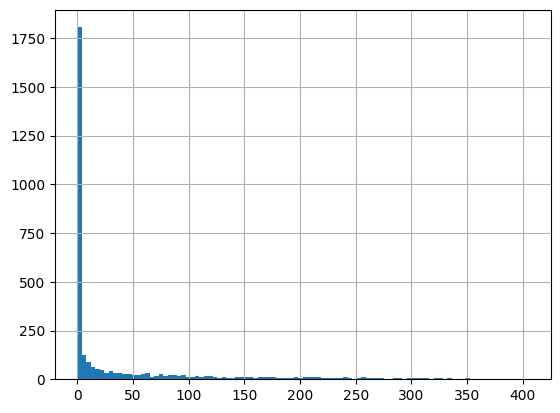

In [43]:
metrics_original[metrics_original['institution_id'] == 'Z04O']['rejected_flat'].hist(bins=100)